In [73]:
# Initial imports
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [74]:
# Load and clean data
df = pd.read_csv("Resources/st_paul_sold_properties .csv")
df.head()

,list_date,list_price,sold_date,sold_price,beds,baths,sqft,lot_sqft,city,street,zip,latitude,longitude
0,2025-01-31,209900.0,2025-03-31,209900,2.0,1.5,904.0,4704.0,Saint Paul,868 Algonquin Ave,55119,44.967562,-93.017718
1,2024-11-15,374900.0,2024-12-13,391000,3.0,1.5,1534.0,4966.0,Saint Paul,1246 Bayard Ave,55116,44.922167,-93.152861
2,2024-12-20,275000.0,2025-01-10,266800,3.0,1.0,1297.0,6534.0,Saint Paul,967 California Ave W,55117,44.991249,-93.140914
3,2025-01-23,500000.0,2025-02-28,505003,3.0,2.0,1636.0,5009.0,Saint Paul,2098 Pinehurst Ave,55116,44.918628,-93.189055
4,2025-03-18,425000.0,2025-04-08,475000,4.0,1.0,1750.0,7362.0,Saint Paul,2129 Sargent Ave,55105,44.935472,-93.190323


In [75]:
# Convert dates
df['list_date'] = pd.to_datetime(df['list_date'], errors='coerce')
df['sold_date'] = pd.to_datetime(df['sold_date'], errors='coerce')

# Drop rows with missing or invalid dates
df = df.dropna(subset=['list_date', 'sold_date'])

# Calculate days_on_market
df['days_on_market'] = (df['sold_date'] - df['list_date']).dt.days
df = df[df['days_on_market'] >= 0]
# Calculate price per sq ft, bed/bath ratio
df['price_per_sqft'] = df['list_price'] / df['sqft']
df['beds_baths_ratio'] = df['beds'] / (df['baths'] + 1)
df['month_listed'] = pd.to_datetime(df['list_date'], errors='coerce').dt.month
df['year_listed'] = pd.to_datetime(df['list_date'], errors='coerce').dt.year

# Drop rows with missing target
df = df.dropna(subset=['days_on_market'])

# Drop unneeded columns
df_model = df.drop(columns=['list_date', 'sold_date', 'city', 'street', 'latitude', 'longitude'], errors='ignore')

# Drop rows with any remaining NaNs
df_model = df_model.dropna()

In [76]:
# Features and target
X = df_model.drop(columns='days_on_market')
y = df_model['days_on_market']

# # Apply log1p transformation to target
# y_log = np.log1p(y)

In [77]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.2, random_state=42)

In [78]:
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import randint

# Define optimized hyperparameters
best_params = {
    'n_estimators': 443,  
    'max_depth': 20,
    'min_samples_split': 2,  
    'min_samples_leaf': 1
}

# Initialize and train the model with optimized parameters
rf_model = RandomForestRegressor(**best_params, random_state=42, bootstrap=True)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

In [79]:
from sklearn.metrics import mean_absolute_error, r2_score

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Model MAE: {mae:.2f}")
print(f"Model R²: {r2:.4f}")

Model MAE: 0.33
Model R²: 0.4819


In [80]:
# Random Forests in sklearn will automatically calculate feature importance
importances = rf_model.feature_importances_
# We can sort the features by their importance
sorted(zip(rf_model.feature_importances_, X.columns), reverse=True)

[(0.23821304746973226, 'year_listed'),
 (0.20086247205009464, 'month_listed'),
 (0.11639609043356382, 'price_per_sqft'),
 (0.09299385237905865, 'sold_price'),
 (0.08146735230969232, 'list_price'),
 (0.07436586791602254, 'lot_sqft'),
 (0.06099659290774621, 'sqft'),
 (0.050690580457074884, 'beds_baths_ratio'),
 (0.050323307207743743, 'zip'),
 (0.017639732427550802, 'beds'),
 (0.01605110444172016, 'baths')]

<Axes: title={'center': 'Features Importances'}, ylabel='1'>

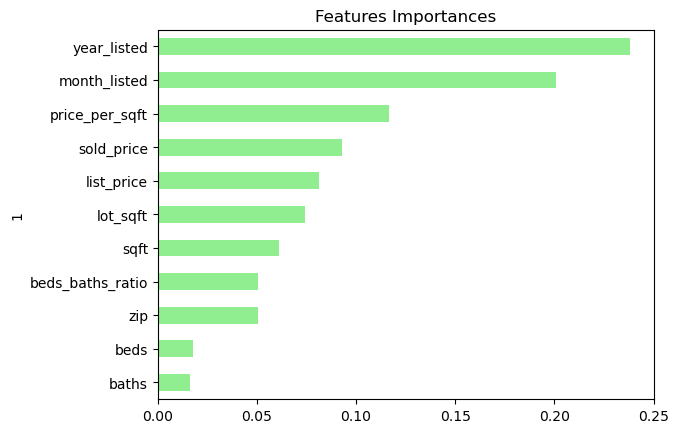

In [81]:
# Visualize the features by importance
importances_df = pd.DataFrame(sorted(zip(rf_model.feature_importances_, X.columns), reverse=True))
importances_df.set_index(importances_df[1], inplace=True)
importances_df.drop(columns=1, inplace=True)
importances_df.rename(columns={0: 'Feature Importances'}, inplace=True)
importances_sorted = importances_df.sort_values(by='Feature Importances')
importances_sorted.plot(kind='barh', color='lightgreen', title= 'Features Importances', legend=False)